In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Training
msft_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Microsoft_stock.csv')

# 10 year stock
wmt_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Walmart_stock.csv')
dg_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/DG_stock.csv')
jnj_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Johnson&Johnson_stock.csv')
jpm_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/JPMorgan_stock.csv')
cfg_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/CitizensFinancialGroup_stock.csv')

# Testing
three_months_wmt = pd.read_csv('/content/drive/MyDrive/Stocks Data/WMT3Months_Stock.csv')
three_months_dg = pd.read_csv('/content/drive/MyDrive/Stocks Data/DG3Months_Stock.csv')
three_months_jnj = pd.read_csv('/content/drive/MyDrive/Stocks Data/JNJ3Months_Stock.csv')
three_months_jpm = pd.read_csv('/content/drive/MyDrive/Stocks Data/JPM3Months_Stock.csv')
three_months_cfg = pd.read_csv('/content/drive/MyDrive/Stocks Data/CFG3Months_Stock.csv')

print("10 years Microsoft Stock for Training:", msft_stock.shape)
print("3 months WMT Stock for Testing :", three_months_wmt.shape)
print("3 months DG Stock for Testing :", three_months_dg.shape)
print("3 months JNJ Stock for Testing :", three_months_jnj.shape)
print("3 months JPM Stock for Testing :", three_months_jpm.shape)
print("3 months CFG Stock for Testing :", three_months_cfg.shape)

10 years Microsoft Stock for Training: (3018, 3)
3 months WMT Stock for Testing : (59, 3)
3 months DG Stock for Testing : (59, 3)
3 months JNJ Stock for Testing : (59, 3)
3 months JPM Stock for Testing : (59, 3)
3 months CFG Stock for Testing : (59, 3)


In [4]:
msft_stock

,Date,Adj Close,Stock Name
0,2013-01-02,22.321140,MSFT
1,2013-01-03,22.022121,MSFT
2,2013-01-04,21.609970,MSFT
3,2013-01-07,21.569563,MSFT
4,2013-01-08,21.456419,MSFT
...,...,...,...
3013,2024-12-20,434.927856,MSFT
3014,2024-12-23,433.583038,MSFT
3015,2024-12-24,437.647369,MSFT
3016,2024-12-26,436.432068,MSFT


In [5]:
# Date Conversion
msft_stock['Date'] = pd.to_datetime(msft_stock['Date'])
three_months_wmt['Date'] = pd.to_datetime(three_months_wmt['Date'])
three_months_dg['Date'] = pd.to_datetime(three_months_wmt['Date'])
three_months_jnj['Date'] = pd.to_datetime(three_months_wmt['Date'])
three_months_jpm['Date'] = pd.to_datetime(three_months_wmt['Date'])
three_months_cfg['Date'] = pd.to_datetime(three_months_wmt['Date'])

# Sort data
msft_stock.sort_values('Date', inplace=True)
three_months_wmt.sort_values('Date', inplace=True)
three_months_dg.sort_values('Date', inplace=True)
three_months_jnj.sort_values('Date', inplace=True)
three_months_jpm.sort_values('Date', inplace=True)
three_months_cfg.sort_values('Date', inplace=True)

# Extract series
train_msft = msft_stock['Adj Close'].values

three_months_test_wmt = three_months_wmt['Adj Close'].values
three_months_test_dg = three_months_dg['Adj Close'].values
three_months_test_jnj = three_months_jnj['Adj Close'].values
three_months_test_jpm = three_months_jpm['Adj Close'].values
three_months_test_cfg = three_months_cfg['Adj Close'].values

three_months_dates_wmt = three_months_wmt['Date'].values
three_months_dates_dg = three_months_dg['Date'].values
three_months_dates_jnj = three_months_jnj['Date'].values
three_months_dates_jpm = three_months_jpm['Date'].values
three_months_dates_cfg = three_months_cfg['Date'].values


In [6]:
train_msft

array([ 22.32114029,  22.02212143,  21.60997009, ..., 437.64736938,
       436.43206787, 428.88110352])

In [7]:
three_months_test_wmt

array([ 89.53704071,  90.31302643,  90.95968628,  90.34287262,
        91.32778931,  92.52160645,  91.05917358,  90.32298279,
        90.87014771,  90.83036041,  91.46707153,  92.60120392,
        92.75043488,  93.32744598,  94.27256775,  96.89897919,
        96.78954315,  96.99846649,  98.14254761,  97.65507507,
        99.02797699, 100.25164032, 101.93295288, 102.32094574,
       100.62969208, 102.39058685, 101.94290161, 103.077034  ,
       104.5096283 , 103.50482941, 103.24616241, 103.46502686,
        96.70995331,  94.29244995,  93.18816376,  97.18749237,
        95.70515442,  96.29212189,  98.10276031,  97.08799744,
        94.48147583,  95.48628998,  94.15317535,  91.24819946,
        87.36826324,  86.99021149,  84.76173401,  84.06533051,
        84.91095734,  87.01010895,  85.14972687,  85.88592529,
        85.36859131,  85.77262115,  87.27897644,  84.55556488,
        85.00447845,  85.42346191,  84.94462585])

In [8]:
three_months_test_dg

array([74.56056213, 73.61414337, 74.77745056, 73.69444275, 71.16079712,
       70.90246582, 71.13098145, 68.93515778, 68.13034821, 68.81593323,
       68.00119019, 71.47874451, 70.26657104, 70.87265778, 71.31977081,
       72.83002472, 72.24380493, 71.57810211, 71.68740082, 70.60438538,
       71.0117569 , 71.33964539, 72.35310364, 72.14444733, 72.02521515,
       73.6646347 , 73.65470123, 73.33675385, 72.37297058, 72.09476471,
       74.54892731, 75.14508057, 75.64187622, 76.19828796, 78.52328491,
       78.07617188, 73.71431732, 73.50566864, 73.70438385, 71.42906189,
       72.45246124, 73.22745514, 75.75117493, 81.31526184, 82.26911926,
       78.13578796, 74.37008667, 79.43738556, 78.51334381, 79.33802795,
       80.88803101, 81.80213165, 81.14635468, 83.12360382, 82.62680817,
       82.05052948, 84.15692902, 86.97872162, 85.54795074])

In [9]:
three_months_test_jnj

array([141.66186523, 141.82910156, 141.30776978, 143.8356781 ,
       139.94052124, 139.73396301, 142.10450745, 142.37992859,
       142.59631348, 145.35046387, 144.62258911, 145.72424316,
       142.8914032 , 144.2389679 , 144.41604614, 150.3866272 ,
       147.91775513, 148.67512512, 150.36695862, 149.65875244,
       149.38334656, 150.9768219 , 152.15718079, 150.99649048,
       150.61286926, 151.71453857, 153.57359314, 152.71783447,
       154.67526245, 153.59324646, 153.6725769 , 156.54792786,
       158.32270813, 160.92044067, 162.34820557, 164.67822266,
       161.69381714, 162.33828735, 163.61732483, 165.85810852,
       164.01391602, 163.71646118, 164.42044067, 165.27313232,
       166.27453613, 164.45018005, 161.46577454, 161.60458374,
       161.42610168, 161.45585632, 162.85386658, 161.60458374,
       161.63432312, 162.23913574, 161.90202332, 159.65132141,
       160.34536743, 161.74339294, 162.31846619])

In [10]:
three_months_test_jpm

array([237.30517578, 240.54833984, 239.37556458, 241.68135071,
       241.64160156, 238.40155029, 242.71499634, 245.95503235,
       250.80516052, 252.71340942, 257.57348633, 261.41976929,
       261.23092651, 264.32192993, 263.21868896, 264.22253418,
       265.50463867, 264.94802856, 266.58795166, 265.66363525,
       265.17663574, 266.29971313, 268.7744751 , 275.2048645 ,
       274.11160278, 269.3807373 , 273.30654907, 273.76376343,
       274.62841797, 274.89675903, 278.23620605, 277.54049683,
       265.16668701, 262.62237549, 259.7401123 , 255.82423401,
       257.20574951, 257.46414185, 263.02984619, 259.02453613,
       248.71801758, 249.99017334, 245.03071594, 240.79679871,
       230.79840088, 227.73724365, 226.50483704, 223.81143188,
       231.01704407, 232.49790955, 233.53155518, 237.64620972,
       237.54681396, 240.15078735, 246.54142761, 249.59263611,
       249.49324036, 246.6010437 , 241.36332703])

In [11]:
three_months_test_cfg

array([42.73789978, 43.67892456, 43.91417313, 43.81615448, 43.8945694 ,
       42.4438324 , 43.2868309 , 44.79637909, 46.14909744, 45.87462997,
       46.59999847, 47.35477448, 46.1000824 , 46.40395355, 46.52157974,
       46.60980225, 46.41375351, 46.67841721, 47.40378571, 47.03792572,
       45.85134506, 46.51385498, 47.1170311 , 47.77953339, 47.39389801,
       46.83027267, 46.64239502, 45.64369583, 45.53492355, 45.83156967,
       46.27653503, 46.85993576, 45.66347122, 44.37801361, 43.87371445,
       43.91326904, 44.48678207, 44.66476822, 45.25805664, 44.54610825,
       43.10243988, 42.85523605, 41.89608765, 41.17425156, 39.36472321,
       39.46360397, 40.01734161, 39.28561401, 40.24476624, 40.40297699,
       40.50185776, 40.89738464, 40.53152466, 40.72928238, 41.76754379,
       41.79720688, 41.52033997, 40.78861237, 39.79980087])

## **WMT Stock Prediction**

### WMT - ARIMA

In [12]:
## Stationarity check when the series are stationary
def make_series_stationary(series, max_diffs=2):
    current_series = series.copy()
    diffs_applied = 0

    for i in range(max_diffs + 1):
        ## Performing Dickey-Fuller test
        result = adfuller(current_series)
        p_value = result[1]

        print(f"\nTest {i+1}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")

        if p_value <= 0.05:
            print("\nSeries is now stationary")
            return current_series, diffs_applied
        elif i < max_diffs:
            print("\nSeries is not stationary. Applying differencing...")
            current_series = np.diff(current_series)
            diffs_applied += 1

    raise ValueError(f"Series could not be made stationary after {max_diffs} differences")

## Make the training series stationary
try:
    print("Checking stationarity of original series...")
    train_stationary, diffs_needed = make_series_stationary(train_msft)

    print(f"\nSuccessfully made series stationary with {diffs_needed} difference(s)")
    print("Proceeding with next steps...")

except ValueError as e:
    print(f"\nError: {e}")
    print("Cannot proceed with analysis - series is not stationary")

Checking stationarity of original series...

Test 1:
ADF Statistic: 1.3144
p-value: 0.9967
Critical Values:
	1%: -3.4325
	5%: -2.8625
	10%: -2.5673

Series is not stationary. Applying differencing...

Test 2:
ADF Statistic: -12.4279
p-value: 0.0000
Critical Values:
	1%: -3.4325
	5%: -2.8625
	10%: -2.5673

Series is now stationary

Successfully made series stationary with 1 difference(s)
Proceeding with next steps...


In [13]:
from statsmodels.tsa.arima.model import ARIMA

## Preparing input sequence
full_series_wmt = wmt_stock['Adj Close'].values

## Using last 10 days of WMT stock before prediction start
time_steps = 10
initial_window = full_series_wmt[-(time_steps + len(three_months_test_wmt)) : -len(three_months_test_wmt)].tolist()

## ARIMA forecasting with sliding window
def evaluate_arima_model_windowed(initial_window, test_series, order):
    history = initial_window.copy()
    predictions = []

    for t in range(len(test_series)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        ## Updating history with actual value
        history.append(test_series[t])

    ## Regression Metrics
    r2 = r2_score(test_series, predictions)
    mae = mean_absolute_error(test_series, predictions)
    mse = mean_squared_error(test_series, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse



WMT Evaluating ARIMA(1, 0, 1)...
R²: 0.8033 | MAE: 1.7780 | MSE: 7.0576 | RMSE: 2.6566

WMT Evaluating ARIMA(0, 1, 1)...
R²: 0.8525 | MAE: 1.5353 | MSE: 5.2910 | RMSE: 2.3002

WMT Evaluating ARIMA(1, 1, 0)...
R²: 0.8749 | MAE: 1.4302 | MSE: 4.4877 | RMSE: 2.1184

WMT Best model: ARIMA(1, 1, 0) with R²: 0.8749

First 10 Predictions vs Actual:
Day 1: Actual = 89.54, Predicted = 79.84
Day 2: Actual = 90.31, Predicted = 89.37
Day 3: Actual = 90.96, Predicted = 90.37
Day 4: Actual = 90.34, Predicted = 91.01
Day 5: Actual = 91.33, Predicted = 90.30
Day 6: Actual = 92.52, Predicted = 91.39
Day 7: Actual = 91.06, Predicted = 92.61
Day 8: Actual = 90.32, Predicted = 90.98
Day 9: Actual = 90.87, Predicted = 90.27
Day 10: Actual = 90.83, Predicted = 90.90


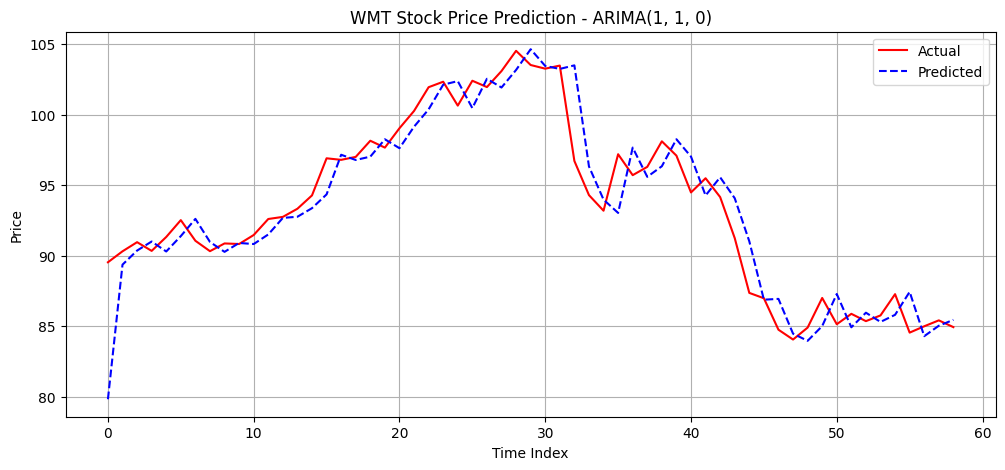

In [14]:
orders_to_try = [(1,0,1), (0,1,1), (1,1,0)]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    print(f"\nWMT Evaluating ARIMA{order}...")
    predictions, r2, mae, mse, rmse = evaluate_arima_model_windowed(initial_window, three_months_test_wmt, order)
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_order = order
        best_predictions = predictions

print(f"\nWMT Best model: ARIMA{best_order} with R²: {best_r2:.4f}")

def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(three_months_test_wmt)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {three_months_test_wmt[i]:.2f}, Predicted = {best_predictions[i]:.2f}")

## best model results
plt.figure(figsize=(12, 5))
plt.plot(three_months_test_wmt, 'r-',label='Actual')
plt.plot(best_predictions, 'b--', label='Predicted')
plt.title(f'WMT Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### WMT - LSTM

In [15]:
## Preparing data
full_series = wmt_stock['Adj Close'].values.reshape(-1, 1)
test_series_wmt = three_months_wmt['Adj Close'].values.reshape(-1, 1)
test_dates = three_months_wmt['Date'].values

## Robust Scaling
scaler = RobustScaler()
scaled_full_series = scaler.fit_transform(full_series)

## Create sequences with timesteps = 10
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

## use all 3018 Microsoft stock for training
time_steps = 10
X_train, y_train = create_sequences(scaled_full_series, time_steps)

In [16]:
X_train

array([[[-0.48210105],
        [-0.48678671],
        [-0.48401784],
        ...,
        [-0.48859719],
        [-0.49211152],
        [-0.48487008]],

       [[-0.48678671],
        [-0.48401784],
        [-0.49104681],
        ...,
        [-0.49211152],
        [-0.48487008],
        [-0.48242046]],

       [[-0.48401784],
        [-0.49104681],
        [-0.489023  ],
        ...,
        [-0.48487008],
        [-0.48242046],
        [-0.4862542 ]],

       ...,

       [[ 2.64706769],
        [ 2.66383432],
        [ 2.62825619],
        ...,
        [ 2.60850177],
        [ 2.56095928],
        [ 2.48349837]],

       [[ 2.66383432],
        [ 2.62825619],
        [ 2.64333877],
        ...,
        [ 2.56095928],
        [ 2.48349837],
        [ 2.57899256]],

       [[ 2.62825619],
        [ 2.64333877],
        [ 2.66874943],
        ...,
        [ 2.48349837],
        [ 2.57899256],
        [ 2.58350128]]])

In [17]:
## LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()  ## Starting input sequence from last 10 days of Walmart
input_sequences = []  ## To store each input sequence used
predictions = []      ## To store predictions

for i in range(len(test_series_wmt)):
    input_sequences.append(input_seq.copy())  ## Save current input sequence

    ## Prediction
    pred = lstm_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating input sequence with actual next price (walk-forward validation)
    next_actual_scaled = scaler.transform(test_series_wmt[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]


WMT LSTM Evaluation:
R²: 0.8622 | MAE: 1.6882 | MSE: 4.9445 | RMSE: 2.2236


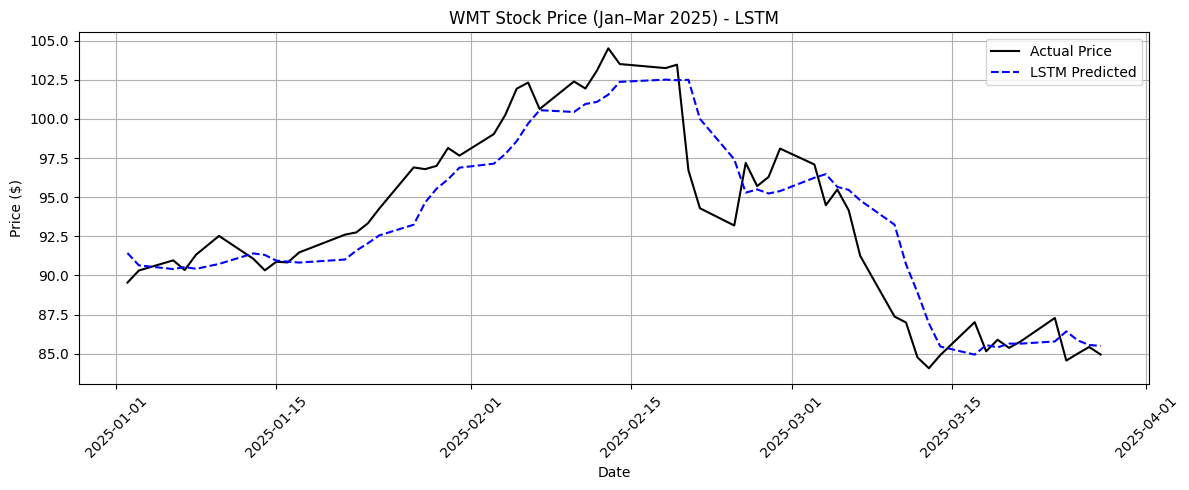


WMT LSTM Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,89.537041,91.427971,0.000000,0.000000
1,2025-01-03,90.313026,90.640633,0.866664,-0.861156
2,2025-01-06,90.959686,90.404686,1.588891,-1.119226
3,2025-01-07,90.342873,90.532539,0.899998,-0.979382
4,2025-01-08,91.327789,90.418922,2.000009,-1.103652


In [18]:
## Inverse transform predictions
lstm_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_lstm = r2_score(three_months_test_wmt, lstm_predicted_prices)
mae_lstm = mean_absolute_error(three_months_test_wmt, lstm_predicted_prices)
mse_lstm = mean_squared_error(three_months_test_wmt, lstm_predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

print("\nWMT LSTM Evaluation:")
print(f"R²: {r2_lstm:.4f} | MAE: {mae_lstm:.4f} | MSE: {mse_lstm:.4f} | RMSE: {rmse_lstm:.4f}")

## Cumulative return calculation
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(test_series_wmt.flatten())
predicted_returns = calculate_cumulative_returns(lstm_predicted_prices)

## Results
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_wmt.flatten(),
    'Predicted Price': lstm_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_wmt.flatten(), 'k-', label='Actual Price')
plt.plot(test_dates, lstm_results['Predicted Price'], 'b--', label='LSTM Predicted')
plt.title('WMT Stock Price (Jan–Mar 2025) - LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nWMT LSTM Model - Actual vs Predicted:")
lstm_results.head()

In [19]:
for i in range(len(test_dates)):
    date = test_dates[i]
    actual_price = test_series_wmt.flatten()[i]
    predicted_price = lstm_predicted_prices[i]
    sequence_unscaled = scaler.inverse_transform(input_sequences[i].reshape(-1, 1)).flatten()

    print(f"\nDate: {date}")
    print(f"Sequence (Walmart - Last 10 Days Before Prediction): {sequence_unscaled}")
    print(f"Input (Last Timestep Value): {sequence_unscaled[-1]:.2f}")
    print(f"Actual Price (Walmart): {actual_price:.2f}")
    print(f"Predicted Price: {predicted_price:.2f}")



Date: 2025-01-02T00:00:00.000000000
Sequence (Walmart - Last 10 Days Before Prediction): [93.7651825  94.38199615 94.92916107 93.06878662 92.91955566 91.76551819
 89.88524628 92.2032547  92.31269836 91.18850708]
Input (Last Timestep Value): 91.19
Actual Price (Walmart): 89.54
Predicted Price: 91.43

Date: 2025-01-03T00:00:00.000000000
Sequence (Walmart - Last 10 Days Before Prediction): [94.38199615 94.92916107 93.06878662 92.91955566 91.76551819 89.88524628
 92.2032547  92.31269836 91.18850708 89.53704071]
Input (Last Timestep Value): 89.54
Actual Price (Walmart): 90.31
Predicted Price: 90.64

Date: 2025-01-06T00:00:00.000000000
Sequence (Walmart - Last 10 Days Before Prediction): [94.92916107 93.06878662 92.91955566 91.76551819 89.88524628 92.2032547
 92.31269836 91.18850708 89.53704071 90.31302643]
Input (Last Timestep Value): 90.31
Actual Price (Walmart): 90.96
Predicted Price: 90.40

Date: 2025-01-07T00:00:00.000000000
Sequence (Walmart - Last 10 Days Before Prediction): [93.0687

### WMT - GRU


WMT GRU Evaluation:
R²: 0.9128 | MAE: 1.3466 | MSE: 3.1300 | RMSE: 1.7692


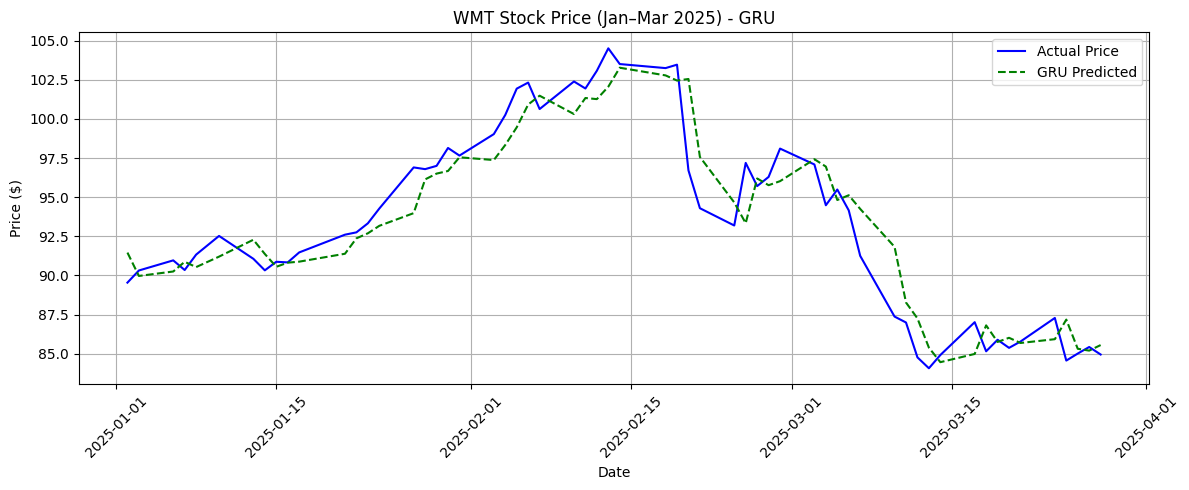


WMT GRU Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,89.537041,91.456810,0.000000,0.000000
1,2025-01-03,90.313026,89.964020,0.866664,-1.632237
2,2025-01-06,90.959686,90.248322,1.588891,-1.321375
3,2025-01-07,90.342873,90.868271,0.899998,-0.643516
4,2025-01-08,91.327789,90.530655,2.000009,-1.012671


In [20]:
## GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='tanh', input_shape=(time_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()
input_sequences = []
predictions = []

for i in range(len(test_series_wmt)):
    input_sequences.append(input_seq.copy())

    ## Prediction
    pred = gru_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating sequence with actual next price
    next_actual_scaled = scaler.transform(test_series_wmt[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
gru_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_gru = r2_score(three_months_test_wmt, gru_predicted_prices)
mae_gru = mean_absolute_error(three_months_test_wmt, gru_predicted_prices)
mse_gru = mean_squared_error(three_months_test_wmt, gru_predicted_prices)
rmse_gru = np.sqrt(mse_gru)

print("\nWMT GRU Evaluation:")
print(f"R²: {r2_gru:.4f} | MAE: {mae_gru:.4f} | MSE: {mse_gru:.4f} | RMSE: {rmse_gru:.4f}")

## Cumulative returns
actual_returns = calculate_cumulative_returns(test_series_wmt.flatten())
predicted_returns = calculate_cumulative_returns(gru_predicted_prices)

## Results
gru_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_wmt.flatten(),
    'Predicted Price': gru_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_wmt.flatten(), 'b-', label='Actual Price')
plt.plot(test_dates, gru_results['Predicted Price'], 'g--', label='GRU Predicted')
plt.title('WMT Stock Price (Jan–Mar 2025) - GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nWMT GRU Model - Actual vs Predicted:")
gru_results.head()


## DG Stock Prediction

### DG - ARIMA


DG Evaluating ARIMA(1, 0, 1)...
R²: 0.7739 | MAE: 1.5062 | MSE: 4.8039 | RMSE: 2.1918

DG Evaluating ARIMA(0, 1, 1)...
R²: 0.8126 | MAE: 1.4249 | MSE: 3.9816 | RMSE: 1.9954

DG Evaluating ARIMA(1, 1, 0)...
R²: 0.8116 | MAE: 1.4257 | MSE: 4.0039 | RMSE: 2.0010

DG Best model: ARIMA(0, 1, 1) with R²: 0.8126

First 10 Predictions vs Actual:
Day 1: Actual = 74.56, Predicted = 80.20
Day 2: Actual = 73.61, Predicted = 74.76
Day 3: Actual = 74.78, Predicted = 73.58
Day 4: Actual = 73.69, Predicted = 74.82
Day 5: Actual = 71.16, Predicted = 73.68
Day 6: Actual = 70.90, Predicted = 71.02
Day 7: Actual = 71.13, Predicted = 70.90
Day 8: Actual = 68.94, Predicted = 71.15
Day 9: Actual = 68.13, Predicted = 68.82
Day 10: Actual = 68.82, Predicted = 68.08


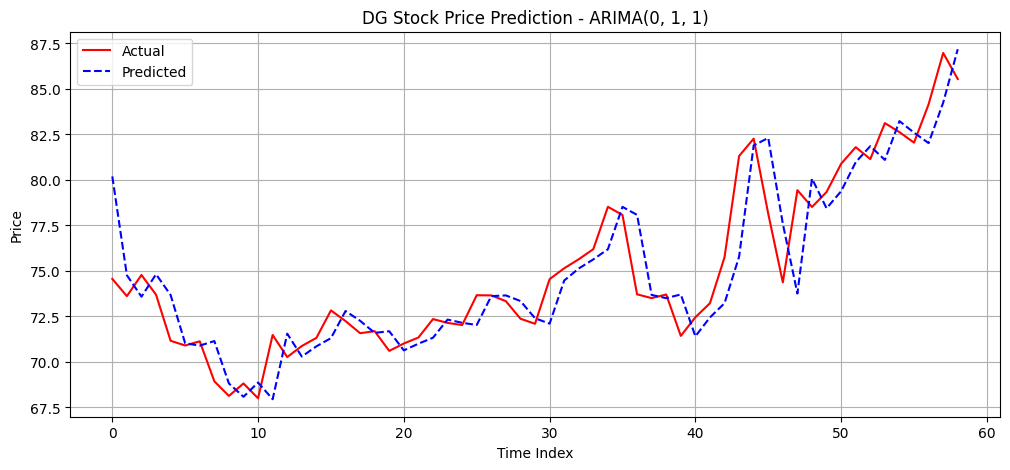

In [21]:
## Preparing input sequence
full_series_dg = dg_stock['Adj Close'].values

## Using last 10 days of DG stock before prediction start
time_steps = 10
initial_window = full_series_dg[-(time_steps + len(three_months_test_dg)) : -len(three_months_test_dg)].tolist()

## ARIMA forecasting with sliding window
def evaluate_arima_model_windowed(initial_window, test_series, order):
    history = initial_window.copy()
    predictions = []

    for t in range(len(test_series)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        ## Updating history with actual value
        history.append(test_series[t])

    ## Regression Metrics
    r2 = r2_score(test_series, predictions)
    mae = mean_absolute_error(test_series, predictions)
    mse = mean_squared_error(test_series, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse

orders_to_try = [(1,0,1), (0,1,1), (1,1,0)]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    print(f"\nDG Evaluating ARIMA{order}...")
    predictions, r2, mae, mse, rmse = evaluate_arima_model_windowed(initial_window, three_months_test_dg, order)
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_order = order
        best_predictions = predictions

print(f"\nDG Best model: ARIMA{best_order} with R²: {best_r2:.4f}")


def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(three_months_test_dg)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {three_months_test_dg[i]:.2f}, Predicted = {best_predictions[i]:.2f}")

## best model results
plt.figure(figsize=(12, 5))
plt.plot(three_months_test_dg, 'r-',label='Actual')
plt.plot(best_predictions, 'b--', label='Predicted')
plt.title(f'DG Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### DG - LSTM


DG LSTM Evaluation:
R²: 0.7932 | MAE: 1.5265 | MSE: 4.3940 | RMSE: 2.0962


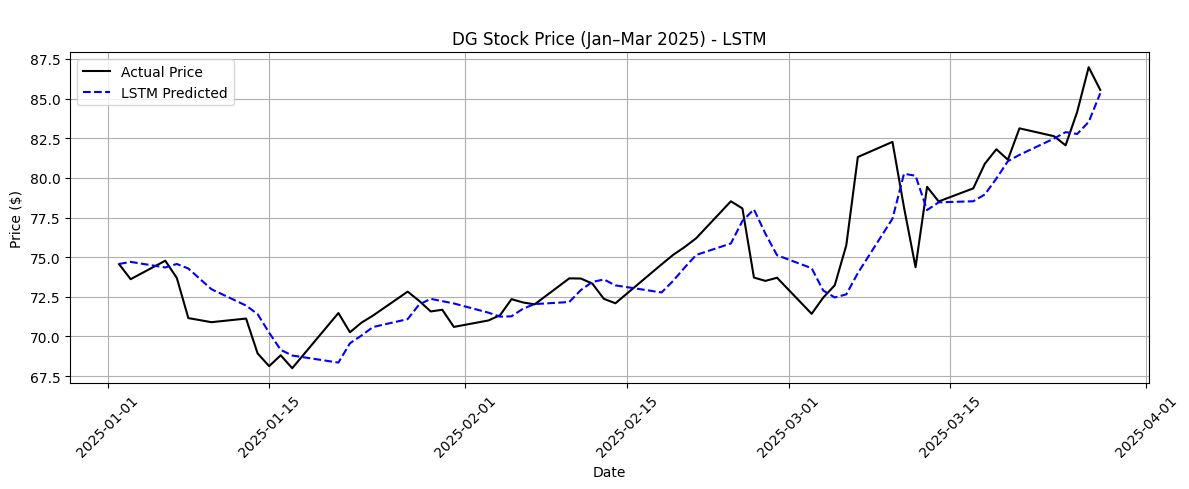


DG LSTM Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,74.560562,74.571915,0.000000,0.000000
1,2025-01-03,73.614143,74.702896,-1.269329,0.175643
2,2025-01-06,74.777451,74.352905,0.290889,-0.293690
3,2025-01-07,73.694443,74.571907,-1.161632,-0.000012
4,2025-01-08,71.160797,74.285339,-4.559736,-0.384295


In [22]:
## Preparing data
full_series = dg_stock['Adj Close'].values.reshape(-1, 1)
test_series_dg = three_months_dg['Adj Close'].values.reshape(-1, 1)
test_dates = three_months_dg['Date'].values

## Robust Scaling
scaler = RobustScaler()
scaled_full_series = scaler.fit_transform(full_series)

## Create sequences with timesteps = 10
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

## use all 3018 Microsoft stock for training
time_steps = 10
X_train, y_train = create_sequences(scaled_full_series, time_steps)

## LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()  ## Starting input sequence from last 10 days of Walmart
input_sequences = []  ## To store each input sequence used
predictions = []      ## To store predictions

for i in range(len(test_series_dg)):
    input_sequences.append(input_seq.copy())  ## Save current input sequence

    ## Prediction
    pred = lstm_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating input sequence with actual next price (walk-forward validation)
    next_actual_scaled = scaler.transform(test_series_dg[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
lstm_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_lstm = r2_score(three_months_test_dg, lstm_predicted_prices)
mae_lstm = mean_absolute_error(three_months_test_dg, lstm_predicted_prices)
mse_lstm = mean_squared_error(three_months_test_dg, lstm_predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

print("\nDG LSTM Evaluation:")
print(f"R²: {r2_lstm:.4f} | MAE: {mae_lstm:.4f} | MSE: {mse_lstm:.4f} | RMSE: {rmse_lstm:.4f}")

## Cumulative return calculation
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(test_series_dg.flatten())
predicted_returns = calculate_cumulative_returns(lstm_predicted_prices)

## Results
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_dg.flatten(),
    'Predicted Price': lstm_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})
plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_dg.flatten(), 'k-', label='Actual Price')
plt.plot(test_dates, lstm_results['Predicted Price'], 'b--', label='LSTM Predicted')
plt.title('\nDG Stock Price (Jan–Mar 2025) - LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nDG LSTM Model - Actual vs Predicted:")
lstm_results.head()

### DG Stock - GRU


DG GRU Evaluation:
R²: 0.8235 | MAE: 1.3775 | MSE: 3.7512 | RMSE: 1.9368


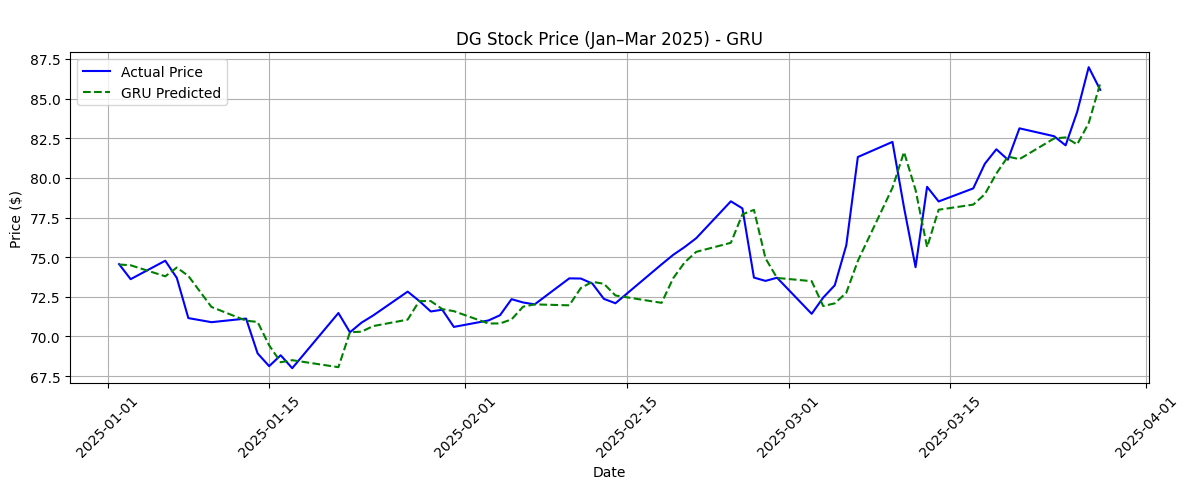


DG GRU Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,74.560562,74.538666,0.000000,0.000000
1,2025-01-03,73.614143,74.490791,-1.269329,-0.064230
2,2025-01-06,74.777451,73.795013,0.290889,-0.997674
3,2025-01-07,73.694443,74.348755,-1.161632,-0.254780
4,2025-01-08,71.160797,73.819351,-4.559736,-0.965023


In [23]:
## GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='tanh', input_shape=(time_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()
input_sequences = []
predictions = []

for i in range(len(test_series_dg)):
    input_sequences.append(input_seq.copy())

    ## Prediction
    pred = gru_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating sequence with actual next price
    next_actual_scaled = scaler.transform(test_series_dg[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
gru_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_gru = r2_score(three_months_test_dg, gru_predicted_prices)
mae_gru = mean_absolute_error(three_months_test_dg, gru_predicted_prices)
mse_gru = mean_squared_error(three_months_test_dg, gru_predicted_prices)
rmse_gru = np.sqrt(mse_gru)

print("\nDG GRU Evaluation:")
print(f"R²: {r2_gru:.4f} | MAE: {mae_gru:.4f} | MSE: {mse_gru:.4f} | RMSE: {rmse_gru:.4f}")

## Cumulative returns
actual_returns = calculate_cumulative_returns(test_series_dg.flatten())
predicted_returns = calculate_cumulative_returns(gru_predicted_prices)

## Results
gru_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_dg.flatten(),
    'Predicted Price': gru_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_dg.flatten(), 'b-', label='Actual Price')
plt.plot(test_dates, gru_results['Predicted Price'], 'g--', label='GRU Predicted')
plt.title('\nDG Stock Price (Jan–Mar 2025) - GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nDG GRU Model - Actual vs Predicted:")
gru_results.head()

## **JNJ Stock Predictions**

### JNJ - ARIMA


JNJ Evaluating ARIMA(1, 0, 1)...
R²: 0.8482 | MAE: 1.9531 | MSE: 10.6480 | RMSE: 3.2631

JNJ Evaluating ARIMA(0, 1, 1)...
R²: 0.9005 | MAE: 1.6288 | MSE: 6.9765 | RMSE: 2.6413

JNJ Evaluating ARIMA(1, 1, 0)...
R²: 0.8967 | MAE: 1.6644 | MSE: 7.2477 | RMSE: 2.6922

JNJ Best model: ARIMA(0, 1, 1) with R²: 0.9005

First 10 Predictions vs Actual:
Day 1: Actual = 141.66, Predicted = 156.60
Day 2: Actual = 141.83, Predicted = 139.08
Day 3: Actual = 141.31, Predicted = 141.84
Day 4: Actual = 143.84, Predicted = 141.29
Day 5: Actual = 139.94, Predicted = 143.89
Day 6: Actual = 139.73, Predicted = 139.99
Day 7: Actual = 142.10, Predicted = 139.74
Day 8: Actual = 142.38, Predicted = 142.08
Day 9: Actual = 142.60, Predicted = 142.38
Day 10: Actual = 145.35, Predicted = 142.59


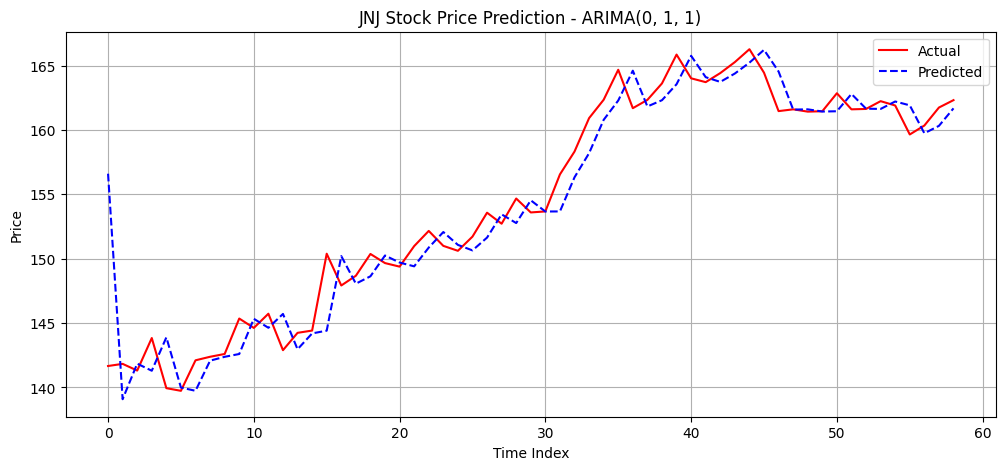

In [24]:
## Preparing input sequence
full_series_jnj = jnj_stock['Adj Close'].values

## Using last 10 days of JNJ stock before prediction start
time_steps = 10
initial_window = full_series_jnj[-(time_steps + len(three_months_test_jnj)) : -len(three_months_test_jnj)].tolist()

## ARIMA forecasting with sliding window
def evaluate_arima_model_windowed(initial_window, test_series, order):
    history = initial_window.copy()
    predictions = []

    for t in range(len(test_series)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        ## Updating history with actual value
        history.append(test_series[t])

    ## Regression Metrics
    r2 = r2_score(test_series, predictions)
    mae = mean_absolute_error(test_series, predictions)
    mse = mean_squared_error(test_series, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse

orders_to_try = [(1,0,1), (0,1,1), (1,1,0)]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    print(f"\nJNJ Evaluating ARIMA{order}...")
    predictions, r2, mae, mse, rmse = evaluate_arima_model_windowed(initial_window, three_months_test_jnj, order)
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_order = order
        best_predictions = predictions

print(f"\nJNJ Best model: ARIMA{best_order} with R²: {best_r2:.4f}")


def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(three_months_test_jnj)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {three_months_test_jnj[i]:.2f}, Predicted = {best_predictions[i]:.2f}")

## best model results
plt.figure(figsize=(12, 5))
plt.plot(three_months_test_jnj, 'r-',label='Actual')
plt.plot(best_predictions, 'b--', label='Predicted')
plt.title(f'JNJ Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### JNJ - LSTM


JNJ LSTM Evaluation:
R²: 0.9562 | MAE: 1.3195 | MSE: 3.0685 | RMSE: 1.7517


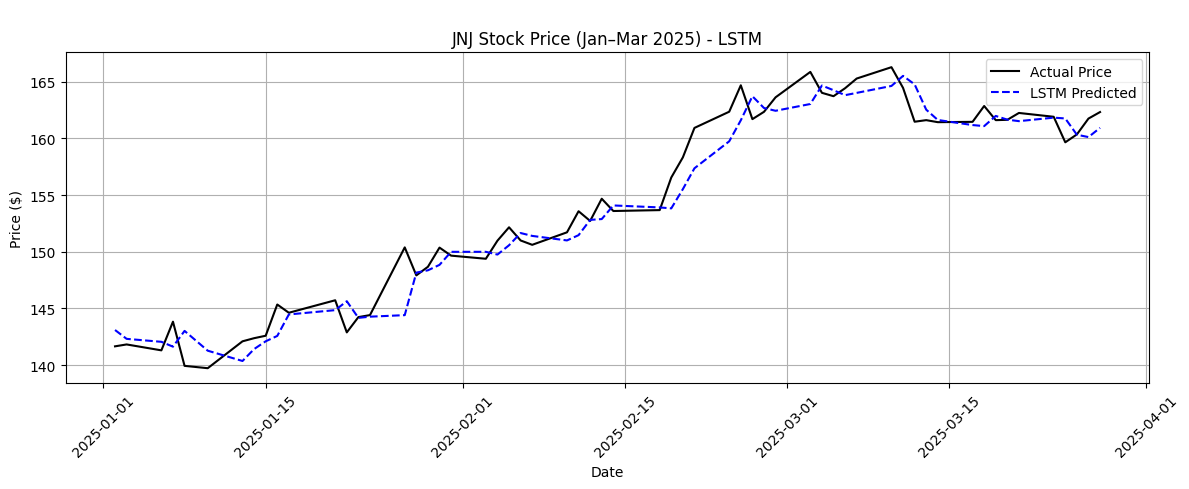


JNJ LSTM Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,141.661865,143.102005,0.000000,0.000000
1,2025-01-03,141.829102,142.322083,0.118053,-0.545013
2,2025-01-06,141.307770,142.060959,-0.249958,-0.727487
3,2025-01-07,143.835678,141.632568,1.534508,-1.026845
4,2025-01-08,139.940521,143.023270,-1.215108,-0.055021


In [25]:
## Preparing data
full_series = jnj_stock['Adj Close'].values.reshape(-1, 1)
test_series_jnj = three_months_jnj['Adj Close'].values.reshape(-1, 1)
test_dates = three_months_jnj['Date'].values

## Robust Scaling
scaler = RobustScaler()
scaled_full_series = scaler.fit_transform(full_series)

## Create sequences with timesteps = 10
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

## use all 3018 Apple stock for training
time_steps = 10
X_train, y_train = create_sequences(scaled_full_series, time_steps)

## LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()  ## Starting input sequence from last 10 days of Walmart
input_sequences = []  ## To store each input sequence used
predictions = []      ## To store predictions

for i in range(len(test_series_jnj)):
    input_sequences.append(input_seq.copy())  ## Save current input sequence

    ## Prediction
    pred = lstm_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating input sequence with actual next price (walk-forward validation)
    next_actual_scaled = scaler.transform(test_series_jnj[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
lstm_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_lstm = r2_score(three_months_test_jnj, lstm_predicted_prices)
mae_lstm = mean_absolute_error(three_months_test_jnj, lstm_predicted_prices)
mse_lstm = mean_squared_error(three_months_test_jnj, lstm_predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

print("\nJNJ LSTM Evaluation:")
print(f"R²: {r2_lstm:.4f} | MAE: {mae_lstm:.4f} | MSE: {mse_lstm:.4f} | RMSE: {rmse_lstm:.4f}")

## Cumulative return calculation
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(test_series_jnj.flatten())
predicted_returns = calculate_cumulative_returns(lstm_predicted_prices)

## Results
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_jnj.flatten(),
    'Predicted Price': lstm_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})
plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_jnj.flatten(), 'k-', label='Actual Price')
plt.plot(test_dates, lstm_results['Predicted Price'], 'b--', label='LSTM Predicted')
plt.title('\nJNJ Stock Price (Jan–Mar 2025) - LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nJNJ LSTM Model - Actual vs Predicted:")
lstm_results.head()

### JNJ - GRU


JNJ GRU Evaluation:
R²: 0.9546 | MAE: 1.4005 | MSE: 3.1840 | RMSE: 1.7844


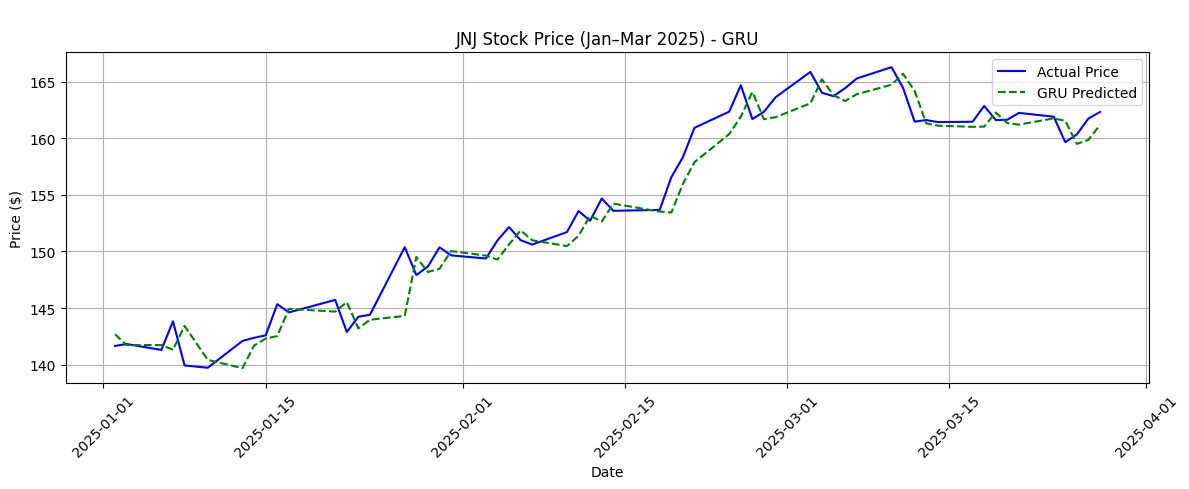


JNJ GRU Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,141.661865,142.688965,0.000000,0.000000
1,2025-01-03,141.829102,141.738846,0.118053,-0.665867
2,2025-01-06,141.307770,141.737473,-0.249958,-0.666827
3,2025-01-07,143.835678,141.319046,1.534508,-0.960076
4,2025-01-08,139.940521,143.426910,-1.215108,0.517166


In [26]:
## GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='tanh', input_shape=(time_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()
input_sequences = []
predictions = []

for i in range(len(test_series_jnj)):
    input_sequences.append(input_seq.copy())

    ## Prediction
    pred = gru_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating sequence with actual next price
    next_actual_scaled = scaler.transform(test_series_jnj[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
gru_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_gru = r2_score(three_months_test_jnj, gru_predicted_prices)
mae_gru = mean_absolute_error(three_months_test_jnj, gru_predicted_prices)
mse_gru = mean_squared_error(three_months_test_jnj, gru_predicted_prices)
rmse_gru = np.sqrt(mse_gru)

print("\nJNJ GRU Evaluation:")
print(f"R²: {r2_gru:.4f} | MAE: {mae_gru:.4f} | MSE: {mse_gru:.4f} | RMSE: {rmse_gru:.4f}")

## Cumulative returns
actual_returns = calculate_cumulative_returns(test_series_jnj.flatten())
predicted_returns = calculate_cumulative_returns(gru_predicted_prices)

## Results
gru_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_jnj.flatten(),
    'Predicted Price': gru_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_jnj.flatten(), 'b-', label='Actual Price')
plt.plot(test_dates, gru_results['Predicted Price'], 'g--', label='GRU Predicted')
plt.title('\nJNJ Stock Price (Jan–Mar 2025) - GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nJNJ GRU Model - Actual vs Predicted:")
gru_results.head()

## **JPM Stock Predictions**

### JPM - ARIMA


JPM Evaluating ARIMA(1, 0, 1)...
R²: 0.4522 | MAE: 5.3360 | MSE: 118.2223 | RMSE: 10.8730

JPM Evaluating ARIMA(0, 1, 1)...
R²: 0.7542 | MAE: 3.9851 | MSE: 53.0444 | RMSE: 7.2832

JPM Evaluating ARIMA(1, 1, 0)...
R²: 0.8065 | MAE: 3.7583 | MSE: 41.7652 | RMSE: 6.4626

JPM Best model: ARIMA(1, 1, 0) with R²: 0.8065

First 10 Predictions vs Actual:
Day 1: Actual = 237.31, Predicted = 201.94
Day 2: Actual = 240.55, Predicted = 221.90
Day 3: Actual = 239.38, Predicted = 240.64
Day 4: Actual = 241.68, Predicted = 239.34
Day 5: Actual = 241.64, Predicted = 241.74
Day 6: Actual = 238.40, Predicted = 241.64
Day 7: Actual = 242.71, Predicted = 238.32
Day 8: Actual = 245.96, Predicted = 242.78
Day 9: Actual = 250.81, Predicted = 246.03
Day 10: Actual = 252.71, Predicted = 250.98


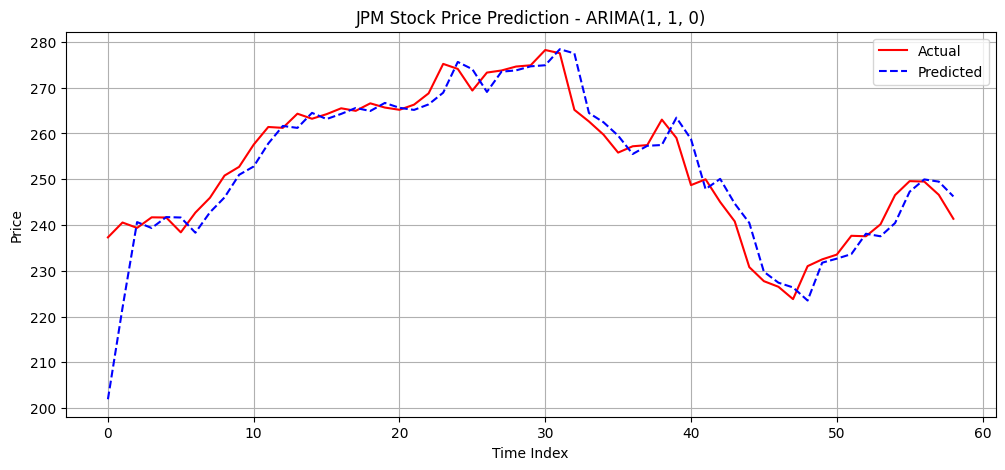

In [27]:
## Preparing input sequence
full_series_jpm = jpm_stock['Adj Close'].values

## Using last 10 days of JPM stock before prediction start
time_steps = 10
initial_window = full_series_jpm[-(time_steps + len(three_months_test_jpm)) : -len(three_months_test_jpm)].tolist()

## ARIMA forecasting with sliding window
def evaluate_arima_model_windowed(initial_window, test_series, order):
    history = initial_window.copy()
    predictions = []

    for t in range(len(test_series)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        ## Updating history with actual value
        history.append(test_series[t])

    ## Regression Metrics
    r2 = r2_score(test_series, predictions)
    mae = mean_absolute_error(test_series, predictions)
    mse = mean_squared_error(test_series, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse

orders_to_try = [(1,0,1), (0,1,1), (1,1,0)]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    print(f"\nJPM Evaluating ARIMA{order}...")
    predictions, r2, mae, mse, rmse = evaluate_arima_model_windowed(initial_window, three_months_test_jpm, order)
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_order = order
        best_predictions = predictions

print(f"\nJPM Best model: ARIMA{best_order} with R²: {best_r2:.4f}")


def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(three_months_test_jpm)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {three_months_test_jpm[i]:.2f}, Predicted = {best_predictions[i]:.2f}")

## best model results
plt.figure(figsize=(12, 5))
plt.plot(three_months_test_jpm, 'r-',label='Actual')
plt.plot(best_predictions, 'b--', label='Predicted')
plt.title(f'JPM Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### JPM - LSTM


JPM LSTM Evaluation:
R²: 0.8705 | MAE: 4.6550 | MSE: 27.9424 | RMSE: 5.2861


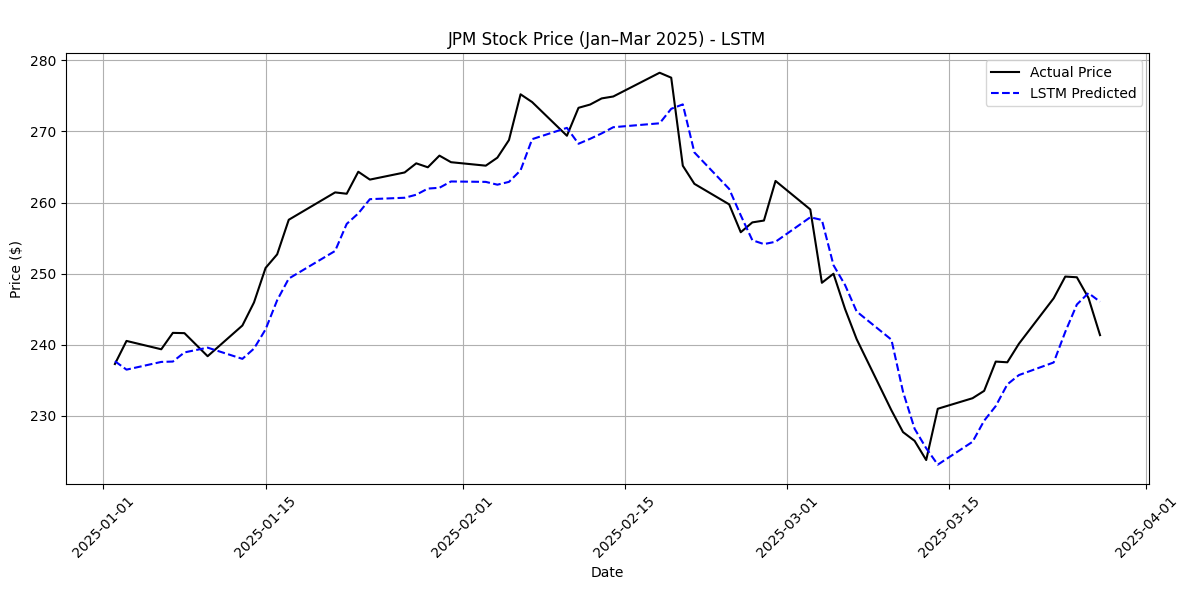


JPM LSTM Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,237.305176,237.698486,0.000000,0.000000
1,2025-01-03,240.548340,236.513367,1.366664,-0.498581
2,2025-01-06,239.375565,237.599579,0.872458,-0.041610
3,2025-01-07,241.681351,237.648788,1.844113,-0.020909
4,2025-01-08,241.641602,238.934647,1.827362,0.520051


In [28]:
## Preparing data
full_series = jpm_stock['Adj Close'].values.reshape(-1, 1)
test_series_jpm = three_months_jpm['Adj Close'].values.reshape(-1, 1)
test_dates = three_months_jpm['Date'].values

## Robust Scaling
scaler = RobustScaler()
scaled_full_series = scaler.fit_transform(full_series)

## Create sequences with timesteps = 10
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

## use all 3018 Apple stock for training
time_steps = 10
X_train, y_train = create_sequences(scaled_full_series, time_steps)

## LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()  ## Starting input sequence from last 10 days of Walmart
input_sequences = []  ## To store each input sequence used
predictions = []      ## To store predictions

for i in range(len(test_series_jpm)):
    input_sequences.append(input_seq.copy())  ## Save current input sequence

    ## Prediction
    pred = lstm_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating input sequence with actual next price (walk-forward validation)
    next_actual_scaled = scaler.transform(test_series_jpm[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
lstm_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_lstm = r2_score(three_months_test_jpm, lstm_predicted_prices)
mae_lstm = mean_absolute_error(three_months_test_jpm, lstm_predicted_prices)
mse_lstm = mean_squared_error(three_months_test_jpm, lstm_predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

print("\nJPM LSTM Evaluation:")
print(f"R²: {r2_lstm:.4f} | MAE: {mae_lstm:.4f} | MSE: {mse_lstm:.4f} | RMSE: {rmse_lstm:.4f}")

## Cumulative return calculation
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(test_series_jpm.flatten())
predicted_returns = calculate_cumulative_returns(lstm_predicted_prices)

## Results
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_jpm.flatten(),
    'Predicted Price': lstm_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_series_jpm.flatten(), 'k-', label='Actual Price')
plt.plot(test_dates, lstm_results['Predicted Price'], 'b--', label='LSTM Predicted')
plt.title('\nJPM Stock Price (Jan–Mar 2025) - LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nJPM LSTM Model - Actual vs Predicted:")
lstm_results.head()

### JPM - GRU


JPM GRU Evaluation:
R²: 0.9192 | MAE: 3.1864 | MSE: 17.4277 | RMSE: 4.1747


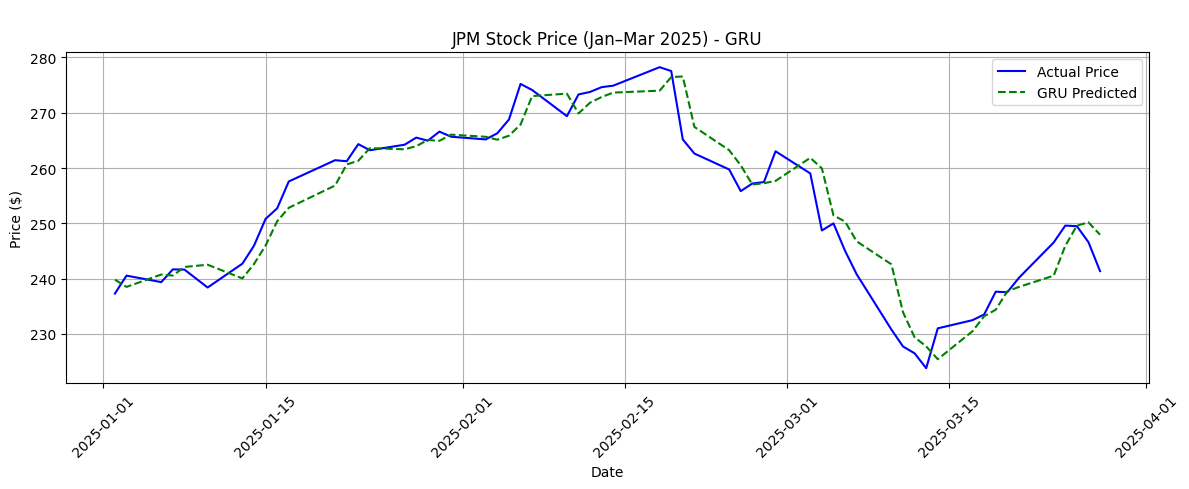


JPM GRU Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,237.305176,239.823410,0.000000,0.000000
1,2025-01-03,240.548340,238.507278,1.366664,-0.548792
2,2025-01-06,239.375565,240.747360,0.872458,0.385261
3,2025-01-07,241.681351,240.562119,1.844113,0.308025
4,2025-01-08,241.641602,242.116821,1.827362,0.956297


In [29]:
## GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='tanh', input_shape=(time_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()
input_sequences = []
predictions = []

for i in range(len(test_series_jpm)):
    input_sequences.append(input_seq.copy())

    ## Prediction
    pred = gru_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating sequence with actual next price
    next_actual_scaled = scaler.transform(test_series_jpm[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
gru_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_gru = r2_score(three_months_test_jpm, gru_predicted_prices)
mae_gru = mean_absolute_error(three_months_test_jpm, gru_predicted_prices)
mse_gru = mean_squared_error(three_months_test_jpm, gru_predicted_prices)
rmse_gru = np.sqrt(mse_gru)

print("\nJPM GRU Evaluation:")
print(f"R²: {r2_gru:.4f} | MAE: {mae_gru:.4f} | MSE: {mse_gru:.4f} | RMSE: {rmse_gru:.4f}")

## Cumulative returns
actual_returns = calculate_cumulative_returns(test_series_jpm.flatten())
predicted_returns = calculate_cumulative_returns(gru_predicted_prices)

## Results
gru_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_jpm.flatten(),
    'Predicted Price': gru_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_jpm.flatten(), 'b-', label='Actual Price')
plt.plot(test_dates, gru_results['Predicted Price'], 'g--', label='GRU Predicted')
plt.title('\nJPM Stock Price (Jan–Mar 2025) - GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nJPM GRU Model - Actual vs Predicted:")
gru_results.head()

## **CFG Stock Predictions**

### CFG - ARIMA


CFG Evaluating ARIMA(1, 0, 1)...
R²: 0.7742 | MAE: 0.8046 | MSE: 1.4782 | RMSE: 1.2158

CFG Evaluating ARIMA(0, 1, 1)...
R²: 0.8783 | MAE: 0.6597 | MSE: 0.7971 | RMSE: 0.8928

CFG Evaluating ARIMA(1, 1, 0)...
R²: 0.8776 | MAE: 0.6626 | MSE: 0.8015 | RMSE: 0.8953

CFG Best model: ARIMA(0, 1, 1) with R²: 0.8783

First 10 Predictions vs Actual:
Day 1: Actual = 42.74, Predicted = 38.85
Day 2: Actual = 43.68, Predicted = 42.53
Day 3: Actual = 43.91, Predicted = 43.73
Day 4: Actual = 43.82, Predicted = 43.94
Day 5: Actual = 43.89, Predicted = 43.80
Day 6: Actual = 42.44, Predicted = 43.91
Day 7: Actual = 43.29, Predicted = 42.23
Day 8: Actual = 44.80, Predicted = 43.38
Day 9: Actual = 46.15, Predicted = 45.00
Day 10: Actual = 45.87, Predicted = 46.36


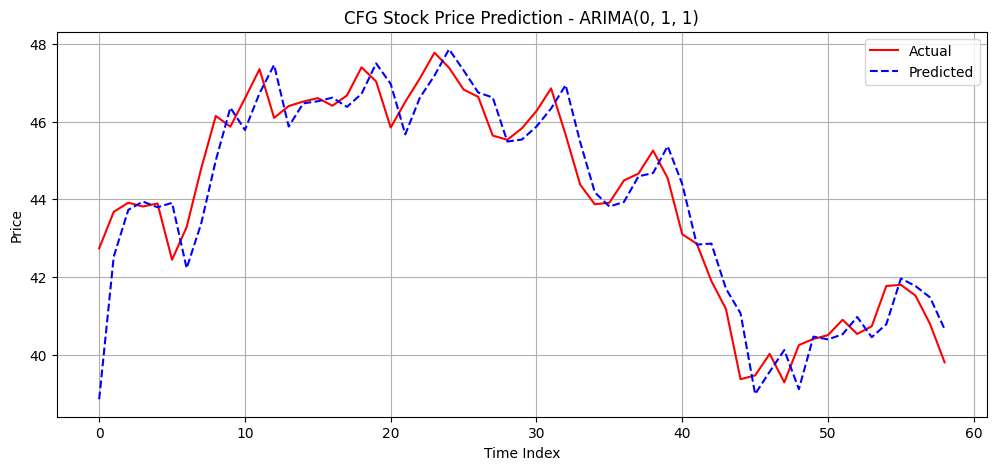

In [30]:
## Preparing input sequence
full_series_cfg = cfg_stock['Adj Close'].values

## Using last 10 days of CFG stock before prediction start
time_steps = 10
initial_window = full_series_cfg[-(time_steps + len(three_months_test_cfg)) : -len(three_months_test_cfg)].tolist()

## ARIMA forecasting with sliding window
def evaluate_arima_model_windowed(initial_window, test_series, order):
    history = initial_window.copy()
    predictions = []

    for t in range(len(test_series)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        ## Updating history with actual value
        history.append(test_series[t])

    ## Regression Metrics
    r2 = r2_score(test_series, predictions)
    mae = mean_absolute_error(test_series, predictions)
    mse = mean_squared_error(test_series, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse

orders_to_try = [(1,0,1), (0,1,1), (1,1,0)]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    print(f"\nCFG Evaluating ARIMA{order}...")
    predictions, r2, mae, mse, rmse = evaluate_arima_model_windowed(initial_window, three_months_test_cfg, order)
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_order = order
        best_predictions = predictions

print(f"\nCFG Best model: ARIMA{best_order} with R²: {best_r2:.4f}")


def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(three_months_test_cfg)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {three_months_test_cfg[i]:.2f}, Predicted = {best_predictions[i]:.2f}")

## best model results
plt.figure(figsize=(12, 5))
plt.plot(three_months_test_cfg, 'r-',label='Actual')
plt.plot(best_predictions, 'b--', label='Predicted')
plt.title(f'CFG Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### CFG - LSTM


CFG LSTM Evaluation:
R²: 0.9117 | MAE: 0.6120 | MSE: 0.5782 | RMSE: 0.7604


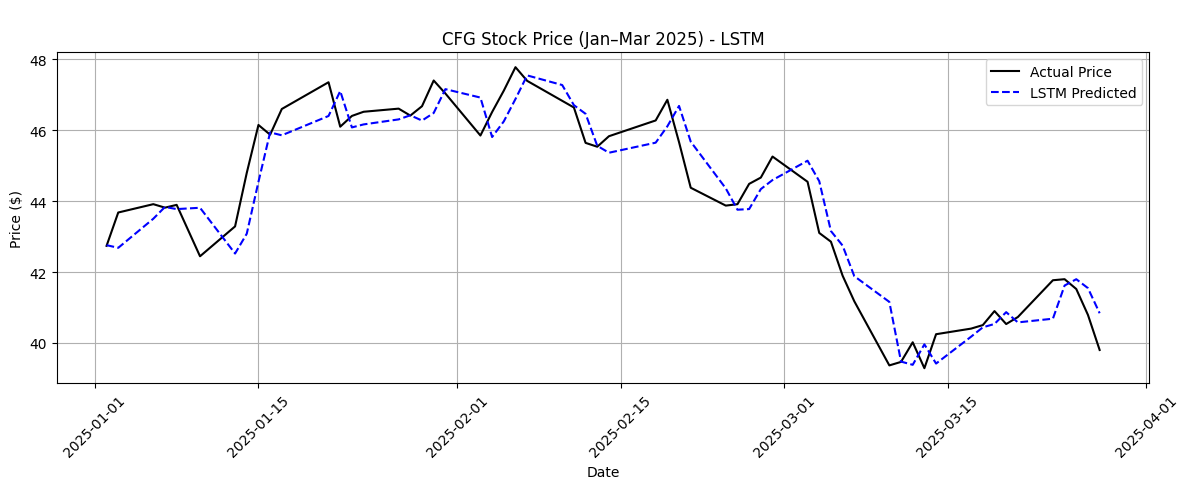


CFG LSTM Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,42.737900,42.757889,0.000000,0.000000
1,2025-01-03,43.678925,42.682308,2.201851,-0.176764
2,2025-01-06,43.914173,43.502872,2.752296,1.742327
3,2025-01-07,43.816154,43.835945,2.522947,2.521300
4,2025-01-08,43.894569,43.775074,2.706426,2.378941


In [31]:
## Preparing data
full_series = cfg_stock['Adj Close'].values.reshape(-1, 1)
test_series_cfg = three_months_cfg['Adj Close'].values.reshape(-1, 1)
test_dates = three_months_cfg['Date'].values

## Robust Scaling
scaler = RobustScaler()
scaled_full_series = scaler.fit_transform(full_series)

## Create sequences with timesteps = 10
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

## use all 3018 Apple stock for training
time_steps = 10
X_train, y_train = create_sequences(scaled_full_series, time_steps)

## LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()  ## Starting input sequence from last 10 days of Walmart
input_sequences = []  ## To store each input sequence used
predictions = []      ## To store predictions

for i in range(len(test_series_cfg)):
    input_sequences.append(input_seq.copy())  ## Save current input sequence

    ## Prediction
    pred = lstm_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating input sequence with actual next price (walk-forward validation)
    next_actual_scaled = scaler.transform(test_series_cfg[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
lstm_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_lstm = r2_score(three_months_test_cfg, lstm_predicted_prices)
mae_lstm = mean_absolute_error(three_months_test_cfg, lstm_predicted_prices)
mse_lstm = mean_squared_error(three_months_test_cfg, lstm_predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

print("\nCFG LSTM Evaluation:")
print(f"R²: {r2_lstm:.4f} | MAE: {mae_lstm:.4f} | MSE: {mse_lstm:.4f} | RMSE: {rmse_lstm:.4f}")

## Cumulative return calculation
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(test_series_cfg.flatten())
predicted_returns = calculate_cumulative_returns(lstm_predicted_prices)

## Results
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_cfg.flatten(),
    'Predicted Price': lstm_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})
plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_cfg.flatten(), 'k-', label='Actual Price')
plt.plot(test_dates, lstm_results['Predicted Price'], 'b--', label='LSTM Predicted')
plt.title('\nCFG Stock Price (Jan–Mar 2025) - LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nCFG LSTM Model - Actual vs Predicted:")
lstm_results.head()

### CFG - GRU


CFG GRU Evaluation:
R²: 0.8255 | MAE: 0.9117 | MSE: 1.1421 | RMSE: 1.0687


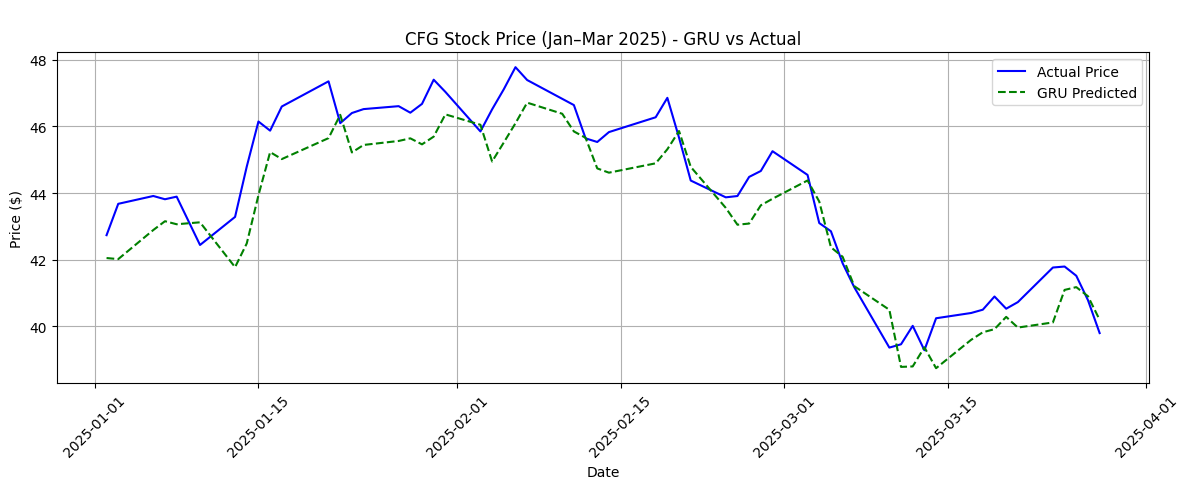


CFG GRU Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,42.737900,42.052345,0.000000,0.000000
1,2025-01-03,43.678925,42.019867,2.201851,-0.077236
2,2025-01-06,43.914173,42.892616,2.752296,1.998150
3,2025-01-07,43.816154,43.157269,2.522947,2.627492
4,2025-01-08,43.894569,43.065914,2.706426,2.410257


In [32]:
## GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='tanh', input_shape=(time_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()
input_sequences = []
predictions = []

for i in range(len(test_series_cfg)):
    input_sequences.append(input_seq.copy())

    ## Prediction
    pred = gru_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating sequence with actual next price
    next_actual_scaled = scaler.transform(test_series_cfg[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
gru_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_gru = r2_score(three_months_test_cfg, gru_predicted_prices)
mae_gru = mean_absolute_error(three_months_test_cfg, gru_predicted_prices)
mse_gru = mean_squared_error(three_months_test_cfg, gru_predicted_prices)
rmse_gru = np.sqrt(mse_gru)

print("\nCFG GRU Evaluation:")
print(f"R²: {r2_gru:.4f} | MAE: {mae_gru:.4f} | MSE: {mse_gru:.4f} | RMSE: {rmse_gru:.4f}")

## Cumulative returns
actual_returns = calculate_cumulative_returns(test_series_cfg.flatten())
predicted_returns = calculate_cumulative_returns(gru_predicted_prices)

## Results
gru_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series_cfg.flatten(),
    'Predicted Price': gru_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series_cfg.flatten(), 'b-', label='Actual Price')
plt.plot(test_dates, gru_results['Predicted Price'], 'g--', label='GRU Predicted')
plt.title('\nCFG Stock Price (Jan–Mar 2025) - GRU vs Actual')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nCFG GRU Model - Actual vs Predicted:")
gru_results.head()